# Clustering beats and fills on Groove Midi Dataset
*https://magenta.tensorflow.org/datasets/e-gmd*

In [38]:
import sys
import os
parent_dir = os.path.abspath(os.path.join('..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)
    
%load_ext autoreload
%autoreload 2

import mirdata
import librosa
import itertools
import umap
import umap.plot
import numpy as np
import pandas as pd
from scripts.data_loaders import load_malian_jembe_dataset, load_candombe_dataset, load_cretan_dances_dataset, load_ballroom_dataset, load_brid_dataset
from sklearn.preprocessing import LabelEncoder
from scripts.scale_transform_magnitude import compute_stm, compute_stm_multi_channel
from scripts.clusterers import select_best_num_clusters
from scripts.helpers import display_interactive_scatter_plot
from pathlib import Path
from tqdm import tqdm

from bokeh.plotting import show


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Smaller version of groove-midi, used for trying out new configurations

In [ ]:
# groove_dataset._metadatafill
metadata = pd.read_csv("../datasets/groove/info.csv")
metadata_beats = metadata[metadata["beat_type"] == "beat"]  # select only beats

metadata_beats = metadata_beats[metadata_beats["duration"] >= 30]
metadata_beats = metadata_beats[metadata_beats["time_signature"] >= "4-4"]

print("duration summary in seconds: \n", metadata_beats["duration"].describe())

metadata_beats["genre"] = metadata_beats["style"].apply(
    lambda x: x.split("/")[0]
)  # create genre column based on style

metadata_beats = metadata_beats[["genre", "style", "audio_filename", "duration"]] # get rid of unnecessary columns
metadata_beats = metadata_beats.reset_index(drop=True) # resetting index is neede for interactive plot

print(metadata_beats.genre.unique())

# Counting occurrences of each genre
genre_counts = metadata_beats['genre'].value_counts()

# Identifying the top n most frequent genres
top_n_genres = genre_counts.head(6).index

metadata_beats = metadata_beats[metadata_beats['genre'].isin(top_n_genres)]

metadata_beats.genre.value_counts()
metadata_beats = metadata_beats.dropna()
metadata_beats = metadata_beats.reset_index(drop=True)

# Function to get the absolute path
def get_absolute_path(file_path):
    return os.path.abspath(os.path.join("/home/stefano/internship/rythmic-pattern-analysis/datasets/groove",file_path))

# Apply the function to the 'audio_filename' column and create a new column 'absolute_path'
metadata_beats['absolute_path'] = metadata_beats['audio_filename'].apply(get_absolute_path)
print(metadata_beats.genre.value_counts())
metadata_beats.absolute_path[0]

In [ ]:
# preparing the data and computing stm
groove_midi_path = Path("../datasets/groove/").expanduser()
features = []
for row in tqdm(metadata_beats.itertuples(index=False), total=metadata_beats.shape[0]): # TODO: find a more efficient way to loop
    try:
        if row.audio_filename == None: continue
        y, sr = librosa.load(groove_midi_path / row.audio_filename, sr=None, duration=30)
        stm, *_ = compute_stm(y=y, sr=sr, num_stm_coefs=400)
        features.append(stm)
        # features.append(np.mean(compute_stm_multi_channel(y=y, sr=sr, channels = [0,5,40], num_stm_coefs=200), axis=0)) 
    except Exception as e:
        print(f"Error: {e}")

### Clustering Analysis

In [ ]:
num_of_clusters = [i for i in range(3, 6)]
results, optimal_k = select_best_num_clusters(
    n_clusters=num_of_clusters, X=np.array(features), dim_reduction="tsne", cluster_method="kmedoids"
)

print(f"Best number of clusters: {optimal_k}; silhouette score: {results.get(optimal_k)}")

In [ ]:
labels = pd.factorize(metadata_beats["genre"])[0]  # integer labels needed for the interactive plot
embeddings = umap.UMAP(metric="cosine").fit_transform(features)  # reduce dimensionality
plot = display_interactive_scatter_plot(embeddings2d=embeddings, labels=labels, hover_data=metadata_beats, output_filename="interactive-test.html")
show(plot)

<hr>

## Extended Groove Midi

In [ ]:
# clean metadata
metadata = pd.read_csv(
    "../datasets/e-gmd-v1.0.0/e-gmd-v1.0.0.csv"
)  # read metadata of extended groove midi

# metadata_beats = metadata[metadata["beat_type"] == "beat"]  # select only beats
metadata_beats = metadata[metadata["beat_type"] == "beat"]  # select only beats

metadata_beats = metadata_beats[metadata_beats["duration"] >= 30]
# metadata_beats = metadata_beats[(metadata_beats["duration"] >= 2) & (metadata_beats["duration"] <= 5)]

metadata_beats = metadata_beats[metadata_beats["time_signature"] >= "4-4"]

print("duration summary in seconds: \n", metadata_beats["duration"].describe())

metadata_beats["genre"] = metadata_beats["style"].apply(
    lambda x: x.split("/")[0]
)  # create genre column based on style

metadata_beats = metadata_beats[["genre", "style", "audio_filename", "duration"]] # get rid of unnecessary columns

metadata_beats.genre.unique()
metadata_beats.genre.value_counts()
metadata_beats = metadata_beats.dropna()

In [ ]:
# Step 1: Filter the indices where the genre is "rock"
rock_indices = metadata_beats[metadata_beats['genre'] == 'rock'].index

# Step 2: Convert the indices to a Pandas Series and randomly select half of these indices
half_rock_indices = pd.Series(rock_indices).sample(frac=0.5, random_state=1)

# Step 3: Drop the rows corresponding to these indices
metadata_beats = metadata_beats.drop(half_rock_indices)

# Counting occurrences of each genre
genre_counts = metadata_beats['genre'].value_counts()

# Identifying the top n most frequent genres
top_n_genres = genre_counts.head(6).index

metadata_beats = metadata_beats[metadata_beats['genre'].isin(top_n_genres)]

print(metadata_beats.genre.value_counts())
metadata_beats

metadata_beats["absolute_path"] = metadata_beats["audio_filename"].apply(
    lambda x: os.path.abspath(Path("../datasets/e-gmd-v1.0.0") / x)
)
metadata_beats

In [ ]:
# preparing the data and computing stm
metadata_beats = metadata_beats.reset_index(drop=True) # resetting index is neede for interactive plot
groove_midi_path = Path("../datasets/e-gmd-v1.0.0")
features = []
for row in tqdm(metadata_beats.itertuples(index=False), total=metadata_beats.shape[0]): # TODO: find a more efficient way to loop
    try:
        y, sr = librosa.load(groove_midi_path / row.audio_filename, sr=8000, duration=30)
        stm, *_ = compute_stm(y=y, sr=sr, num_stm_coefs=200, autocor_window_type="hamming", with_padding=False)
        features.append(stm)
    except Exception as e:
        print(f"Error: {e}")

### K-Means clustering and Silhouette analysis
*https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py*

The plot on the left-hand side displays the silhouette score. The silhouette score measures how similar an object is to its own cluster compared to other clusters. 

A high silhouette score indicates that clusters are well-separated, while a low score suggests overlapping clusters or misclassification.

From the thickness of the silhouette plot the cluster size can be visualized.


In [ ]:
num_of_clusters = [i for i in range(3, 7)]
results, optimal_k = select_best_num_clusters(
    n_clusters=num_of_clusters, X=np.array(features), dim_reduction="tsne", cluster_method="kmedoids"
)

print(f"Best number of clusters: {optimal_k}; silhouette score: {results.get(optimal_k)}")

### Visualize data with interactive UMAP plot

*https://umap-learn.readthedocs.io/en/latest/plotting.html#interactive-plotting-and-hover-tools*

In [ ]:
labels = pd.factorize(metadata_beats["genre"])[0]  # integer labels needed for the interactive plot
embeddings = umap.UMAP(metric="cosine").fit_transform(features)  # reduce dimensionality

plot = display_interactive_scatter_plot(embeddings2d=embeddings, labels=labels, hover_data = metadata_beats, output_filename="groove_beats_interactive.html")
show(plot)


# p = umap.plot.interactive(
#     reducer, labels=labels, hover_data=metadata_beats, point_size=3,
# )  # interactive plot, hover_data can be customized

# umap.plot.output_file("groove_midi_beats.html") # save the plot locally
# umap.plot.output_notebook() # display inline in notebook
# umap.plot.show(p)

<hr>

# Clustering on Candombe, Malian Jembè, GreekDances, Ballroom and Cuban Salsa

In [53]:
# define parameters to compute scale transform magnitude
stm_params = {"mel_flag" : True, "with_padding" : True, "n_mels" : 40, "autocor_window_type" : "hamming", "num_stm_coefs" : 400}

In [54]:
features_mj, labels_mj, hover_data_mj = load_malian_jembe_dataset(multi_channel_stm=False, stm_params=stm_params)
hover_data_mj

Processing annotation file: MJ_Maraka_1_Annotation.csv
Processing audio file: ../datasets/MJ/Media/MJ_Maraka/MJ_Maraka_1_J1.wav
Processing audio file: ../datasets/MJ/Media/MJ_Maraka/MJ_Maraka_1_J2.wav
Processing audio file: ../datasets/MJ/Media/MJ_Maraka/MJ_Maraka_1_D1.wav
Processing annotation file: MJ_Maraka_3_Annotation.csv
Processing audio file: ../datasets/MJ/Media/MJ_Maraka/MJ_Maraka_3_D1.wav
Processing audio file: ../datasets/MJ/Media/MJ_Maraka/MJ_Maraka_3_J2.wav
Processing audio file: ../datasets/MJ/Media/MJ_Maraka/MJ_Maraka_3_J1.wav
Processing annotation file: MJ_Maraka_2_Annotation.csv
Processing audio file: ../datasets/MJ/Media/MJ_Maraka/MJ_Maraka_2_D1.wav
Processing audio file: ../datasets/MJ/Media/MJ_Maraka/MJ_Maraka_2_J1.wav
Processing audio file: ../datasets/MJ/Media/MJ_Maraka/MJ_Maraka_2_J2.wav
Processing annotation file: MJ_Maraka_6_Annotation.csv
Processing audio file: ../datasets/MJ/Media/MJ_Maraka/MJ_Maraka_6_J2.wav
Processing audio file: ../datasets/MJ/Media/MJ_Mar

,pattern,instrument,tradition,label
0,basic theme 1,J1,Maraka,Maraka
1,basic theme 2,J1,Maraka,Maraka
2,basic theme 3,J1,Maraka,Maraka
3,improvisation 1,J1,Maraka,Maraka
4,theme 2,J1,Maraka,Maraka
...,...,...,...,...
372,basic pattern 1,J1,Manjanin,Manjanin
373,impros,J1,Manjanin,Manjanin
374,heating up,J1,Manjanin,Manjanin
375,impro,J1,Manjanin,Manjanin


In [55]:
features_candombe, labels_candombe, hover_data_candombe = load_candombe_dataset(multi_channel_stm=False, stm_params=stm_params)
hover_data_candombe

Processing file: UC_241_Chico.wav
Processing file: UC_241_Piano.wav
Processing file: UC_241_Repique.wav
Processing file: UC_211_Repique.wav
Processing file: UC_211_Piano.wav
Processing file: UC_211_Chico.wav
Processing file: UC_231_Repique.wav
Processing file: UC_231_Piano.wav
Processing file: UC_231_Chico.wav
Processing file: UC_213_Chico.wav
Processing file: UC_213_Piano.wav
Processing file: UC_213_Repique.wav
Processing file: UC_312_Chico.wav
Processing file: UC_312_Repique1.wav
Processing file: UC_312_Piano.wav
Processing file: UC_312_Repique2.wav
Processing file: UC_242_Piano.wav
Processing file: UC_242_Chico.wav
Processing file: UC_242_Repique.wav
Processing file: UC_232_Chico.wav
Processing file: UC_232_Piano.wav
Processing file: UC_232_Repique.wav
Processing file: UC_212_Piano.wav
Processing file: UC_212_Repique.wav
Processing file: UC_212_Chico.wav
Processing file: UC_222_Chico.wav
Processing file: UC_222_Piano.wav
Processing file: UC_222_Repique.wav
Processing file: UC_321_Pi

,pattern,instrument,tradition,label
0,0,Chico,Candombe,Chico
1,1,Chico,Candombe,Chico
2,2,Chico,Candombe,Chico
3,3,Chico,Candombe,Chico
4,0,Piano,Candombe,Piano
...,...,...,...,...
200,0,Chico,Candombe,Chico
201,1,Chico,Candombe,Chico
202,2,Chico,Candombe,Chico
203,3,Chico,Candombe,Chico


In [56]:
features_cretan, labels_cretan, hover_data_cretan = load_cretan_dances_dataset(multi_channel_stm=False, stm_params=stm_params)
hover_data_cretan

Processing folder: maleviziotis
Processing folder: kalamatianos
Processing folder: sousta
Processing folder: kontilies
Processing folder: pentozalis
Processing folder: syrtos


,pattern,instrument,tradition,label
0,07.Malevuziwths_lyr1,None,CretanDances,maleviziotis
1,020_M_A_lyr1,None,CretanDances,maleviziotis
2,13-Maleviziwtis_lyr1,None,CretanDances,maleviziotis
3,12-Malevizwtis_lyr1,None,CretanDances,maleviziotis
4,10-Meleviziwtis_lyr1,None,CretanDances,maleviziotis
...,...,...,...,...
174,01 - st_alargino taksidi soy_lyr1,None,CretanDances,syrtos
175,"13-Nous Taksideuths , X.Stivaktakis_lyr1",None,CretanDances,syrtos
176,044_M_A_lyr1,None,CretanDances,syrtos
177,09 Surto Apokorwniwtiko_lyr1,None,CretanDances,syrtos


In [57]:
features_ballroom, labels_ballroom, hover_data_ballroom = load_ballroom_dataset(multi_channel_stm=False, stm_params=stm_params)
hover_data_ballroom

Processing folder: Samba
Processing folder: Rumba-Misc
Processing folder: Tango
Processing folder: VienneseWaltz
Processing folder: Quickstep
Processing folder: Waltz
Processing folder: Rumba-American
Processing folder: ChaChaCha
Processing folder: Rumba-International
Processing folder: Jive
Features shape: 698 -- labels shape: 698


,pattern,instrument,tradition,label
0,Media-103607,None,Ballroom,samba
1,Media-106107,None,Ballroom,samba
2,Media-104102,None,Ballroom,samba
3,Media-104001,None,Ballroom,samba
4,Media-103504,None,Ballroom,samba
...,...,...,...,...
693,Media-105414,None,Ballroom,jive
694,Albums-Pais_Tropical-13,None,Ballroom,jive
695,Media-104017,None,Ballroom,jive
696,Media-103919,None,Ballroom,jive


In [58]:
features_brid, labels_brid, hover_data_brid = load_brid_dataset(multi_channel_stm=False, stm_params=stm_params)
hover_data_brid

Processing folder: Instrumentalist #1
Tamborim
Surdo
Cuica
Shaker
Reco-reco
Pandeiro
Agogo
Caixa
Tanta
Repique
Processing folder: Instrumentalist #2
Tamborim


/home/stefano/internship/rythmic-pattern-analysis/scripts/data_loaders.py:27: UserWarning: PySoundFile failed. Trying audioread instead.
  try:
/home/stefano/internship/rythmic-pattern-analysis/.rhythm/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Surdo
Cuica
Shaker
Reco-reco
Pandeiro
Agogo
Caixa
Tanta
Repique
Processing folder: Instrumentalist #3
Tamborim


/home/stefano/internship/rythmic-pattern-analysis/scripts/data_loaders.py:27: UserWarning: PySoundFile failed. Trying audioread instead.
  try:
/home/stefano/internship/rythmic-pattern-analysis/.rhythm/lib/python3.11/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Surdo
Cuica
Shaker
Reco-reco
Pandeiro
Agogo
Caixa
Tanta
Repique


,pattern,instrument,tradition
0,Samba,Tamborim 2,Brazilian
1,Partido alto,Tamborim 2,Brazilian
2,Samba-enredo,Tamborim 2,Brazilian
3,Samba-enredo,Tamborim 3,Brazilian
4,Virada (Samba-enredo),Tamborim 3,Brazilian
...,...,...,...
226,Virada (Partido alto),Repique 1,Brazilian
227,Samba,Repique 3,Brazilian
228,Partido alto,Repique 3,Brazilian
229,Samba-enredo,Repique 3,Brazilian


In [59]:
combined_features = list(itertools.chain(features_mj, features_candombe, features_cretan, features_ballroom, features_brid))
combined_labels = list(itertools.chain(hover_data_mj["label"], hover_data_candombe["label"], hover_data_cretan["label"], hover_data_ballroom["label"], labels_brid))
combined_hover_data = pd.concat([hover_data_mj, hover_data_candombe, hover_data_cretan, hover_data_ballroom, hover_data_brid]).reset_index(drop=True)

### K-Means clustering and Silhouette analysis


Average silhouette score with 3 clusters: 0.21114


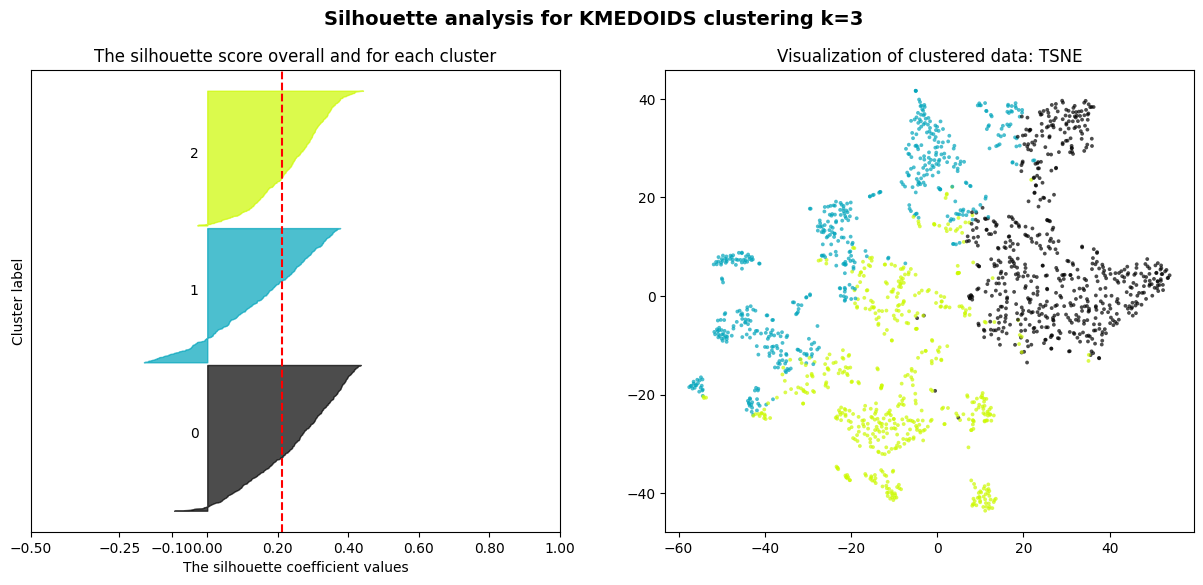

Average silhouette score with 4 clusters: 0.19685


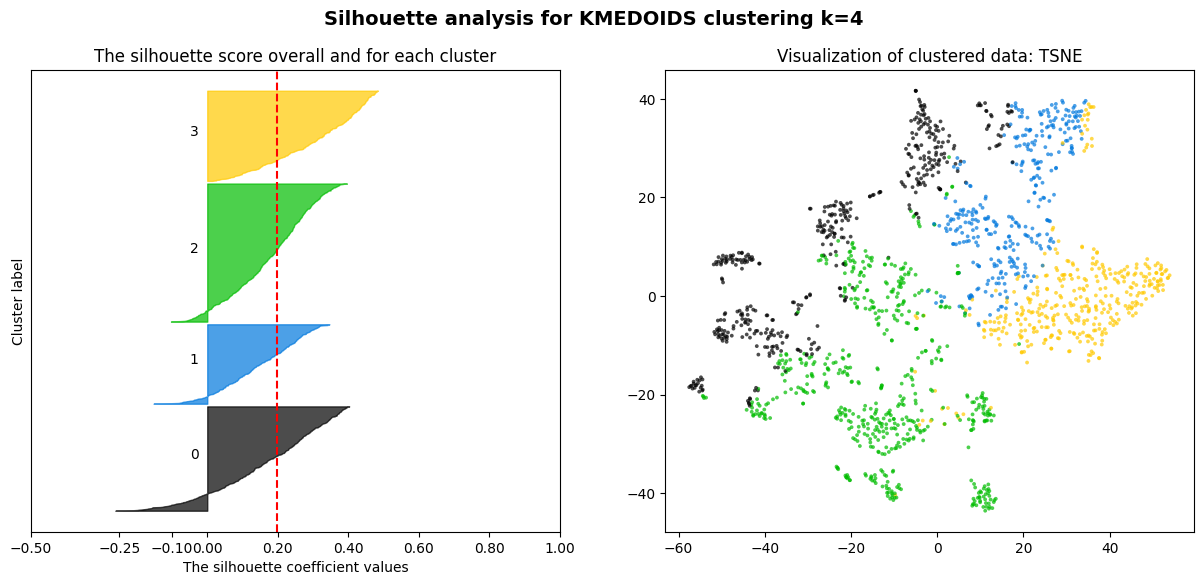

Average silhouette score with 5 clusters: 0.17248


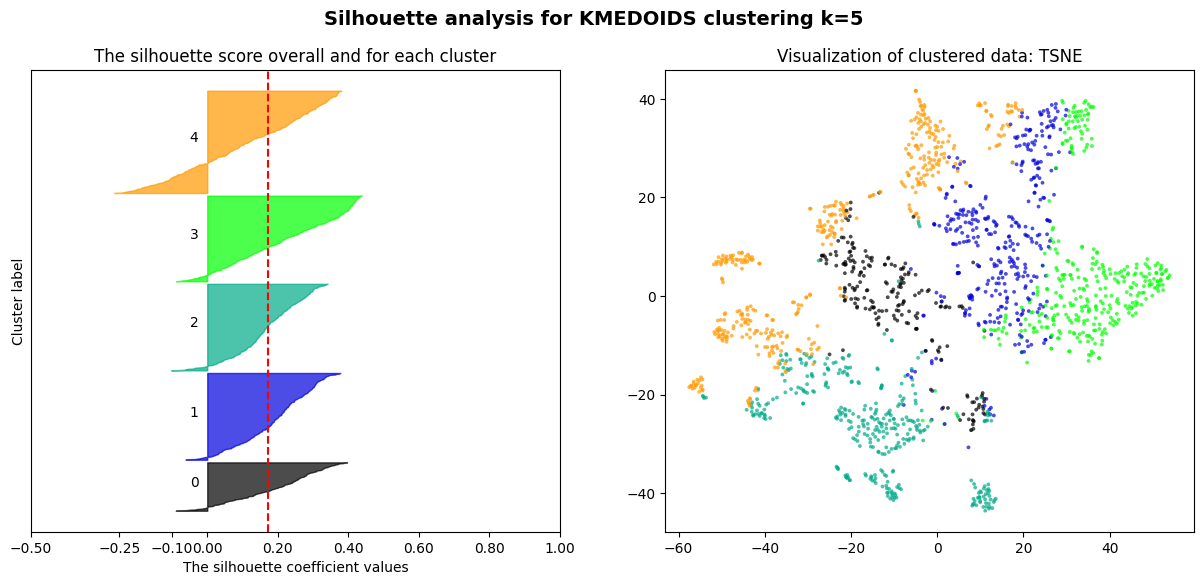

Average silhouette score with 6 clusters: 0.19045


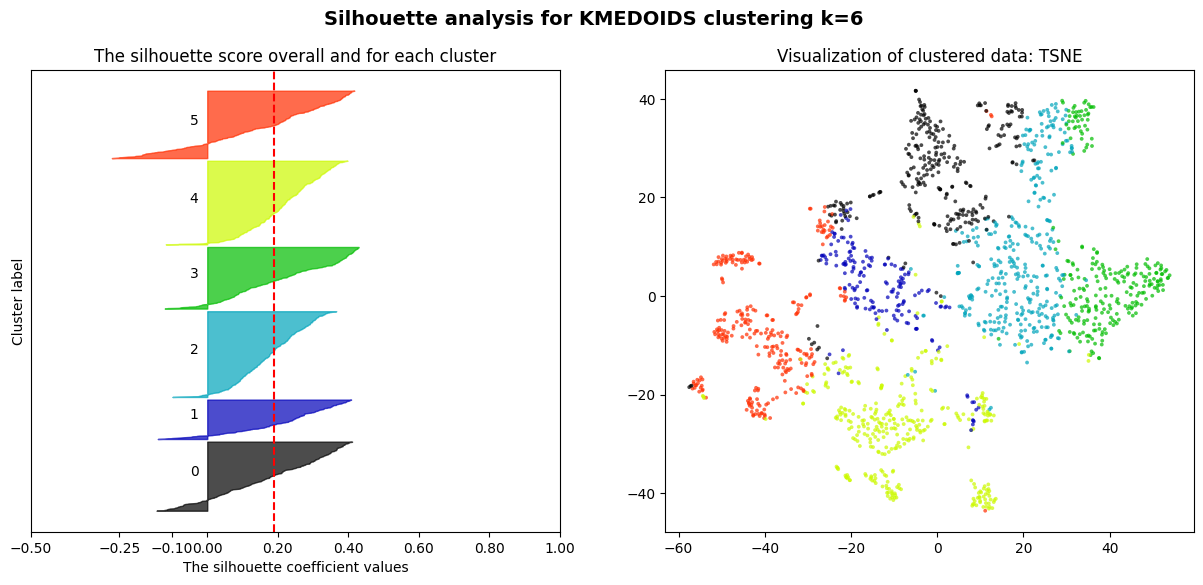

Average silhouette score with 7 clusters: 0.16691


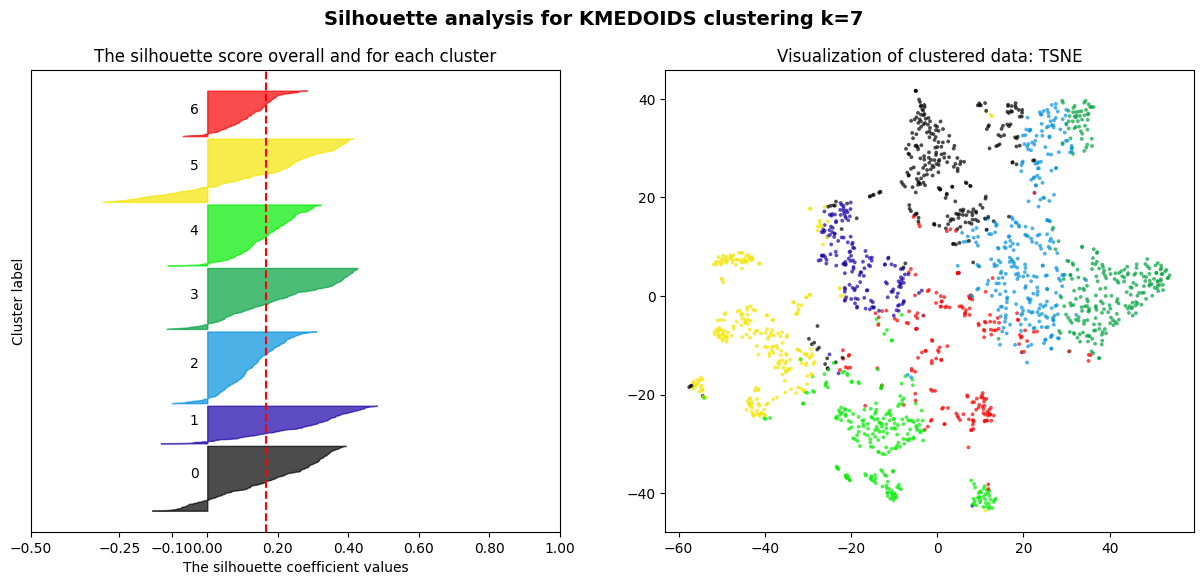

Best number of clusters: 3; silhouette score: 0.21114


In [60]:
num_of_clusters = [i for i in range(3, 8)]
results, optimal_k = select_best_num_clusters(
    n_clusters=num_of_clusters, X=np.array(combined_features), dim_reduction="tsne", cluster_method="kmedoids"
)

print(f"Best number of clusters: {optimal_k}; silhouette score: {results.get(optimal_k)}")

### Visualize data with interactive UMAP plot

In [61]:
encoded_labels = LabelEncoder().fit_transform(combined_labels)  # integer labels needed for the interactive plot
reducer = umap.UMAP(metric="cosine").fit(combined_features) # https://umap-learn.readthedocs.io/en/latest/parameters.html#basic-umap-parameters

p = umap.plot.interactive(
    reducer, labels=encoded_labels, hover_data=combined_hover_data, point_size=4,
)  # interactive plot, hover_data can be customized

umap.plot.output_file("clustering_unlabeled_multi_channel.html") # save the plot locally
umap.plot.output_notebook() # display inline in notebook
umap.plot.show(p)

Loading BokehJS ...